To properly use any sensor fusion algorithm, its a good idea to know how the eerror in our sensor looks like.

The point of this notebook is to find the degree of different types of noise 

## Get Data -> `data: np.array[-1,6]` 

In [ ]:
!pip install gdown > /dev/null

In [ ]:
!gdown "https://drive.google.com/uc?id=18z_4YV_wA9BTYzN58of9BDDEaA4Ongf1&export=download"
filename = "300821_vn1000_very_long_sample_in_metal.csv"
# filename = "270821_vn100_very_long_sample.csv"

Downloading...
From: https://drive.google.com/uc?id=18z_4YV_wA9BTYzN58of9BDDEaA4Ongf1&export=download
To: /content/300821_vn1000_very_long_sample_in_metal.csv
100% 88.2M/88.2M [00:00<00:00, 190MB/s]


In [ ]:
import numpy as np
data = np.loadtxt(filename, delimiter=",", skiprows=1)
data.shape

## Preliminary Plots

- Orien: `data[:, 0:3]` should be constant
  - Need to get variance
  - Try to estimate bias/drift (?)

- Accel: `data[:, 3:6]` should all be zero after correction.
  - Need to get variance across small ranges
  - Try to estimate initial bias and bias drift

In [ ]:
import matplotlib.pyplot as plt

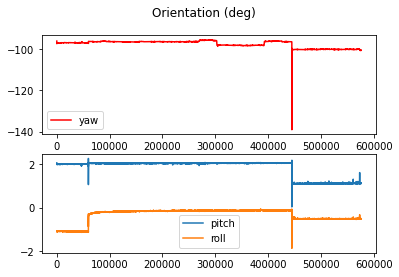

In [ ]:
fig, ax = plt.subplots(2)

ax[0].plot(data[:, 0], label='yaw', color='red')
ax[0].legend()
lines = ax[1].plot(data[:,1:3])
ax[1].legend(lines, "pitch roll".split(' '))
fig.suptitle("Orientation (deg)");

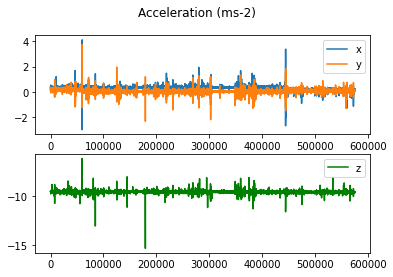

In [ ]:
fig, ax = plt.subplots(2)

lines = ax[0].plot(data[:,3:5])
ax[0].legend(lines, "x y".split(' '))

ax[1].plot(data[:, 5], label='z', color='green')
ax[1].legend()
fig.suptitle("Acceleration (ms-2)");

### Hist Plots

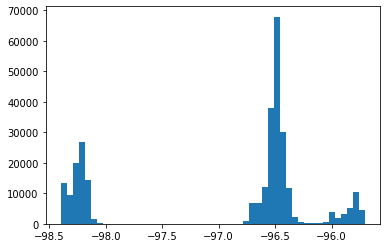

In [ ]:
d = data[100000:400000, 0]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

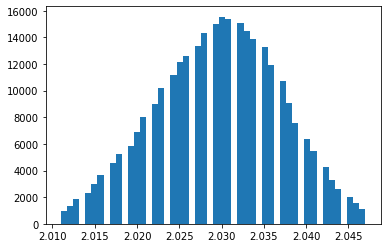

In [ ]:
d = data[100000:400000, 1]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

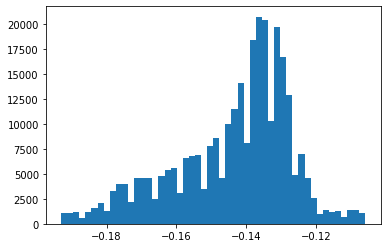

In [ ]:
d = data[100000:400000, 2]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

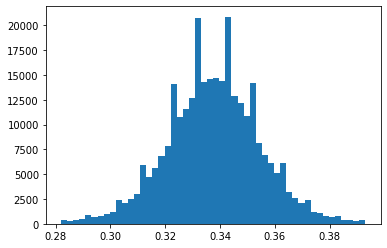

In [ ]:
d = data[100000:400000, 3]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

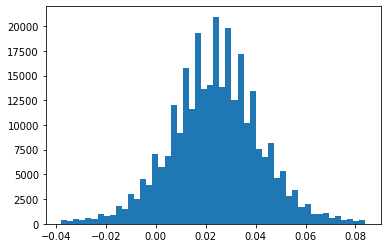

In [ ]:
d = data[100000:400000, 4]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

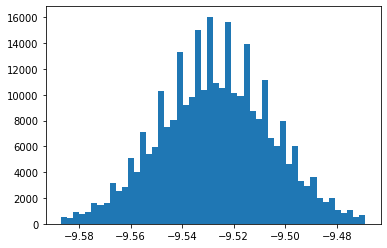

In [ ]:
d = data[100000:400000, 5]
plt.hist(d, bins=50, range=(np.percentile(d, 1), np.percentile(d, 99)))
plt.show()

In [ ]:
np.percentile(data[:,3:5], 1), np.percentile(data[:,3:5], 99)

(-0.018, 0.377)

### Moving Average Plots

In [ ]:
def moving_average(x, w: int):
    return np.convolve(x, np.ones(w), 'valid') / w

# a_avg = np.vstack([moving_average(d, int(1e1)) for d in data[:,3:6].T]).T

# fig, ax = plt.subplots(2)
# lines = ax[0].plot(a_avg[:,0:2])
# ax[0].legend(lines, "x y".split(' '))
# ax[1].plot(a_avg[:, 2], label='z', color='green')
# ax[1].legend()
# fig.suptitle("Acceleration (ms-2), averaged onver 1e1 samples");

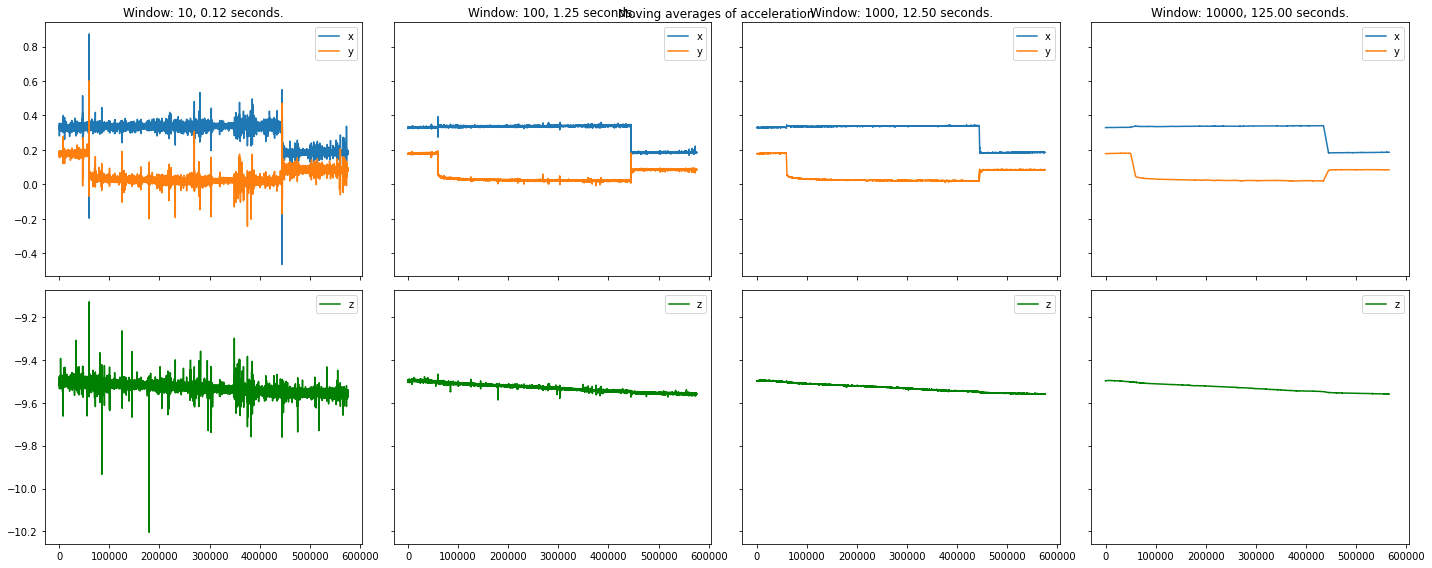

In [ ]:
windows = (1e1,1e2,1e3,1e4) #,1e5,1e6)

fig, ax = plt.subplots(2, len(windows), figsize=(5 * len(windows), 8), sharey='row', sharex=
                       True)
for i, win in enumerate(windows):
  a_avg = np.vstack([moving_average(d, int(win)) for d in data[:,3:6].T]).T
  ax[0, i].set_title(f"Window: {win:.0f}, {win/80:.2f} seconds.")
  lines = ax[0, i].plot(a_avg[:, 0:2])
  ax[0, i].legend(lines, "x y".split(' '))
  ax[1, i].plot(a_avg[:, 2], label='z', color='green')
  ax[1, i].legend()

fig.suptitle("Moving averages of acceleration")
plt.tight_layout()
fig.show()

# Allan Variance

### Allan variance Code

In [ ]:
# FROM: https://github.com/nmayorov/allan-variance
# Author: Nikolay Mayorov <nikolay.mayorov@zoho.com>

from __future__ import division
import numpy as np
import pandas as pd
from scipy.optimize import nnls


def _compute_cluster_sizes(n_samples, dt, tau_min, tau_max, n_clusters):
    if tau_min is None:
        min_size = 1
    else:
        min_size = int(tau_min / dt)

    if tau_max is None:
        max_size = n_samples // 10
    else:
        max_size = int(tau_max / dt)

    result = np.logspace(np.log2(min_size), np.log2(max_size),
                         num=n_clusters, base=2)

    return np.unique(np.round(result)).astype(int)


def allan_variance(x, dt=1, tau_min=None, tau_max=None,
                   n_clusters=100, input_type='mean'):
    """Compute Allan variance (AVAR).
    Consider an underlying measurement y(t). Our sensors output integrals of
    y(t) over successive time intervals of length dt. These measurements
    x(k * dt) form the input to this function.
    Allan variance is defined for different averaging times tau = m * dt as
    follows::
        AVAR(tau) = 1/2 * <(Y(k + m) - Y(k))>,
    where Y(j) is the time average value of y(t) over [k * dt, (k + m) * dt]
    (call it a cluster), and < ... > means averaging over different clusters.
    If we define X(j) being an integral of x(s) from 0 to dt * j,
    we can rewrite the AVAR as  follows::
        AVAR(tau) = 1/(2 * tau**2) * <X(k + 2 * m) - 2 * X(k + m) + X(k)>
    We implement < ... > by averaging over different clusters of a given sample
    with overlapping, and X(j) is readily available from x.
    Parameters
    ----------
    x : ndarray, shape (n, ...)
        Sensor readings, interpretation depends on `input_type` argument.
        Assumed to vary along the 0-th axis.
    dt : float, optional
        Sampling period. Default is 1.
    tau_min : float or None, optional
        Minimum averaging time to use. If None (default), it is assigned equal
        to `dt`.
    tau_max : float or None, optional
        Maximum averaging time to use. If None (default), it is chosen
        automatically such that to averaging is done over 10 *independent*
        clusters.
    n_clusters : int, optional
        Number of clusters to compute Allan variance for. The averaging times
        will be spread approximately uniform in a log scale. Default is 100.
    input_type : {'mean', 'increment', 'integral'}, optional
        How to interpret the input data:
            - 'mean': `x` is assumed to contain mean values of y over
              successive time intervals.
            - 'increment': `x` is assumed to contain integral increments over
              successive time intervals.
            - 'integral': `x` is assumed to contain cumulative integral of
              y from the time start.
        Note that 'mean' can be used when passing filtered and sampled value
        of y. But in this case generally the filtering process affects
        properties of the underlying signal y and "effective" Allan variance
        is computed, i.e. you can use obtained parameters when working with
        the sampled signal.
    Returns
    -------
    tau : ndarray
        Averaging times for which Allan variance was computed, 1-d array.
    avar : ndarray
        Values of AVAR. The 0-th dimension is the same as for `tau`. The
        trailing dimensions match ones for `x`.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Allan_variance
    """
    ALLOWED_INPUT_TYPES = ['mean', 'increment', 'integral']

    if input_type not in ALLOWED_INPUT_TYPES:
        raise ValueError("`input_type` must be one of {}."
                         .format(ALLOWED_INPUT_TYPES))

    x = np.asarray(x, dtype=float)
    if input_type == 'integral':
        X = x
    else:
        X = np.cumsum(x, axis=0)

    cluster_sizes = _compute_cluster_sizes(len(x), dt, tau_min, tau_max,
                                           n_clusters)

    avar = np.empty(cluster_sizes.shape + X.shape[1:])
    for i, k in enumerate(cluster_sizes):
        c = X[2*k:] - 2 * X[k:-k] + X[:-2*k]
        avar[i] = np.mean(c**2, axis=0) / k / k

    if input_type == 'mean':
        avar *= 0.5
    else:
        avar *= 0.5 / dt**2

    return cluster_sizes * dt, avar


def params_from_avar(tau, avar, effects=None, sensor_names=None):
    """Estimate noise parameters from Allan variance.
    The parameters being estimated are typical for inertial sensors:
    quantization noise, additive white noise, flicker noise (long term bias
    instability), random walk and linear ramp (this is a deterministic effect).
    The parameters are estimated using linear least squares with weights
    inversely proportional to the values of Allan variance. That is the sum of
    relative error is minimized. This approach is approximately equivalent of
    doing estimation in the log-log scale.
    Parameters
    ----------
    tau : ndarray, shape (n,)
        Values of averaging time.
    avar : ndarray, shape (n,) or (n, m)
        Values of Allan variance corresponding to `tau`.
    effects : list or None, optional
        Which effects to estimate. Allowed effects are 'quantization', 'white',
        'flicker', 'walk', 'ramp'. If None (default), estimate all of the
        mentioned above effects.
    sensor_names : list or None, optional
        How to name sensors in the output. If None (default), use integer
        values as names.
    Returns
    -------
    params : pandas DataFrame or Series
        Estimated parameters.
    prediction : ndarray, shape (n,) or (n, m)
        Predicted values of Allan variance using the estimated parameters.
    """
    ALLOWED_EFFECTS = ['quantization', 'white', 'flicker', 'walk', 'ramp']

    avar = np.asarray(avar)
    single_series = avar.ndim == 1
    if single_series:
        avar = avar[:, None]

    if effects is None:
        effects = ALLOWED_EFFECTS
    elif not set(effects) <= set(ALLOWED_EFFECTS):
        raise ValueError("Unknown effects are passed.")

    n = len(tau)

    A = np.empty((n, 5))
    A[:, 0] = 3 / tau**2
    A[:, 1] = 1 / tau
    A[:, 2] = 2 * np.log(2) / np.pi
    A[:, 3] = tau / 3
    A[:, 4] = tau**2 / 2
    mask = ['quantization' in effects,
            'white' in effects,
            'flicker' in effects,
            'walk' in effects,
            'ramp' in effects]

    A = A[:, mask]
    effects = np.asarray(ALLOWED_EFFECTS)[mask]

    params = []
    prediction = []

    for column in range(avar.shape[1]):
        avar_single = avar[:, column]
        A_scaled = A / avar_single[:, None]
        x = nnls(A_scaled, np.ones(n))[0]
        prediction.append(A_scaled.dot(x) * avar_single)
        params.append(np.sqrt(x))

    params = np.asarray(params)
    prediction = np.asarray(prediction).T

    params = pd.DataFrame(params, index=sensor_names, columns=effects)

    if single_series:
        params = params.iloc[0]
        prediction = prediction[:, 0]

    return params, prediction

In [ ]:
from scipy.optimize import nnls

nnls?

### Try allan variance to get params

0.32930600000000004 0.3022271041666667 0.18572500000000003
quantization    0.015148
white           0.207603
flicker         0.000000
walk            0.134285
ramp            0.003414
Name: 0, dtype: float64


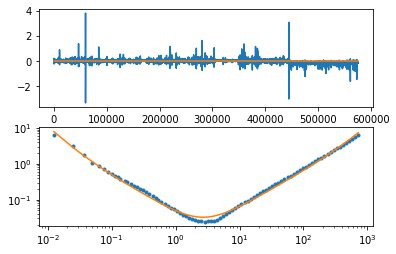

In [ ]:
d = data[:,3]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)
print(params)

0.178172 0.054558369791666665 0.084829
quantization    0.016698
white           0.198763
flicker         0.000000
walk            0.133907
ramp            0.002713
Name: 0, dtype: float64


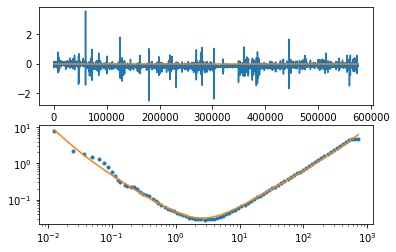

In [ ]:
d = data[:,4]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)
print(params)

-9.497866 -9.53067353125 -9.559038999999999
quantization    0.006369
white           0.240959
flicker         0.032301
walk            0.000000
ramp            0.000773
Name: 0, dtype: float64
0.0023552166593868236


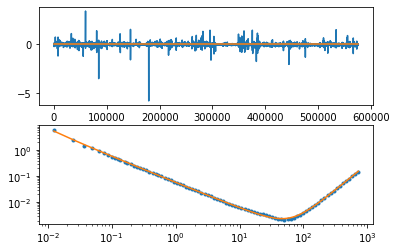

In [ ]:
d = data[:,5]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)

print(params)
print(np.min(av_pred))

### With Orien ==> Useless

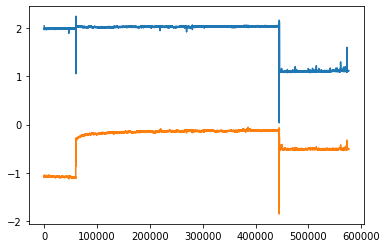

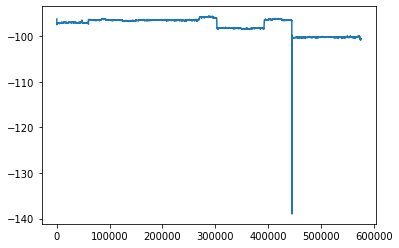

In [ ]:
plt.subplots()[1].plot(data[:, 1:3])
plt.subplots()[1].plot(data[:, 0])

-97.16250699999999 -97.61971393749997 -100.70255900000001
quantization    0.000000
white           0.000000
flicker         1.787111
walk            5.074341
ramp            0.000000
Name: 0, dtype: float64
1.5166047268450031


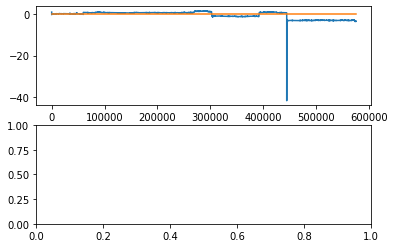

In [ ]:
d = data[:,0]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
# ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
# ax[1].loglog(tau, av_pred)

print(params)
print(np.min(av_pred))

-0.0009440000000000026 -7.697930031128547e-06 0.00011299999999999955
quantization    0.000000
white           0.026840
flicker         0.005432
walk            0.000000
ramp            0.000000
Name: 0, dtype: float64
1.4022541812504104e-05


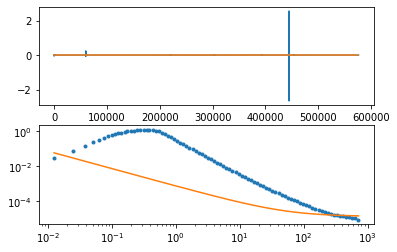

In [ ]:
d = np.diff(data[:,0])

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
# ax[0].plot(d + 0.1 * np.arange(len(d))/16e4 - np.mean(d[:int(1e3)]))
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)

print(params)
print(np.min(av_pred))

1.987389 1.8158535729166667 1.1140170000000003


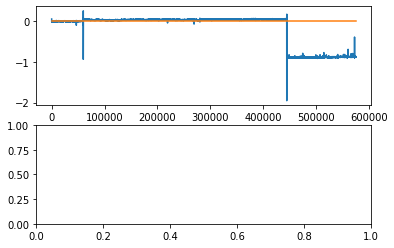

In [ ]:
d = data[:,1]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
# ax[0].plot(d + 0.1 * np.arange(len(d))/16e4 - np.mean(d[:int(1e3)]))
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

-5.499999999999994e-05 -1.6284750494358497e-06 -8.000000000000006e-06
quantization    0.000918
white           0.012364
flicker         0.000000
walk            0.000000
ramp            0.000000
Name: 0, dtype: float64
2.1233927548021884e-07


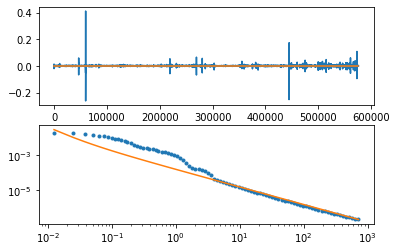

In [ ]:
d = np.diff(data[:,1])

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
# ax[0].plot(d + 0.1 * np.arange(len(d))/16e4 - np.mean(d[:int(1e3)]))
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)

print(params)
print(np.min(av_pred))

-1.076747 -0.32897199826388895 -0.508125


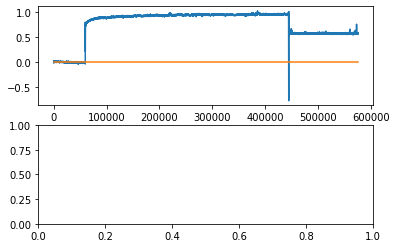

In [ ]:
d = data[:,2]

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

1.6999999999999905e-05 1.0034739643645215e-06 3.0000000000000026e-06
quantization    0.000390
white           0.011155
flicker         0.000000
walk            0.000000
ramp            0.000000
Name: 0, dtype: float64
1.728395445357003e-07


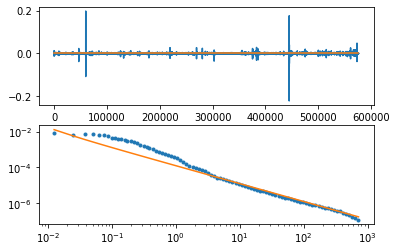

In [ ]:
d = np.diff(data[:,2])

print(np.mean(d[:int(1e3)]), np.mean(d[:]), np.mean(d[-int(1e3):]))

fig, ax = plt.subplots(2)
# ax[0].plot(d + 0.1 * np.arange(len(d))/16e4 - np.mean(d[:int(1e3)]))
ax[0].plot(d - np.mean(d[:int(1e3)]))
ax[0].plot([0, len(d)], [0,0])

tau, av = allan_variance(d, 1.0/80, input_type='increment')
ax[1].loglog(tau, av, '.')
params, av_pred = params_from_avar(tau, av)
ax[1].loglog(tau, av_pred)

print(params)
print(np.min(av_pred))

# AA